In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [59]:
# Define paths
PICTURES_PATH = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\pictures")
CSV_PATH = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\annotations\Labels_Picture.csv")

# Load and preprocess the data
def load_data():
    # Read CSV file with semicolon delimiter
    df = pd.read_csv(CSV_PATH, delimiter=';')
    print(f"Loaded {len(df)} labeled images from CSV")
    print(f"Available columns: {df.columns.tolist()}")
    print(f"Number of columns: {len(df.columns)}")
    
    file_column = df.columns[0]
    print(f"Using '{file_column}' as the file column")
    
    # Find category/label column (look for variations)
    category_column = df.columns[1]
    print(f"Using '{category_column}' as the category column")
    
    print(f"\nFirst few rows of data:")
    print(df[[file_column, category_column]].head())
    
    print("\nCategory distribution:")
    print(df[category_column].value_counts())
    
    # Convert labels to numeric
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[category_column])
    
    # Check if pictures directory exists
    print(f"\nChecking pictures directory: {PICTURES_PATH}")
    print(f"Directory exists: {PICTURES_PATH.exists()}")
    
    if not PICTURES_PATH.exists():
        raise ValueError(f"Pictures directory does not exist: {PICTURES_PATH}")
    
    # Load and preprocess images
    X = []
    valid_indices = []
    error_count = 0
    
    print(f"\nProcessing {len(df)} image entries...")
    
    for idx, filename in enumerate(df[file_column]):
        try:
            # Construct full path to image
            img_path = PICTURES_PATH / filename
            
            if not img_path.exists():
                # Try without extension if original doesn't exist
                if '.' not in filename:
                    # Try common image extensions
                    for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                        img_path_with_ext = PICTURES_PATH / (filename + ext)
                        if img_path_with_ext.exists():
                            img_path = img_path_with_ext
                            break
                
                if not img_path.exists():
                    if error_count < 5:  # Only show first 5 errors
                        print(f"Image file not found: {filename}")
                    error_count += 1
                    continue
                
            # Load and preprocess image
            img = load_img(img_path, target_size=(224, 224))  # ResNet50 input size
            img_array = img_to_array(img)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
            X.append(img_array)
            valid_indices.append(idx)
            
            # Progress indicator
            if (idx + 1) % 20 == 0:
                print(f"Processed {idx + 1}/{len(df)} images")
                
        except Exception as e:
            if error_count < 5:  # Only show first 5 errors
                print(f"Error loading {filename}: {e}")
            error_count += 1
            continue
    
    if len(X) == 0:
        print("\nERROR: No images were successfully loaded!")
        print("Debug information:")
        print(f"Pictures directory: {PICTURES_PATH}")
        print(f"CSV entries (first 10): {df[file_column].head(10).tolist()}")
        
        # Check for common file extensions
        all_files = list(PICTURES_PATH.glob("*"))
        extensions = set(f.suffix.lower() for f in all_files if f.is_file())
        print(f"File extensions found in directory: {extensions}")
        
        raise ValueError("No images could be loaded. Check that image files exist in the pictures directory.")
    
    X = np.array(X)
    y = y[valid_indices]
    
    print(f"\nSUCCESS: Loaded {len(X)} images out of {len(df)} total entries")
    if error_count > 5:
        print(f"Failed to load: {error_count} images (showing first 5 errors only)")
    else:
        print(f"Failed to load: {error_count} images")
    print(f"Image array shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Number of categories: {len(label_encoder.classes_)}")
    print(f"Categories: {list(label_encoder.classes_)}")
    
    return X, y, label_encoder

In [60]:
# Inspect CSV file structure and directory
CSV_PATH = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\annotations\Labels_Picture.csv")
PICTURES_PATH = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\pictures")

print("=== CSV FILE INSPECTION ===")
# Try reading with semicolon delimiter
df = pd.read_csv(CSV_PATH, delimiter=';')
print("CSV file columns:", df.columns.tolist())
print("\nFirst few rows of the CSV file:")
print(df.head())
print(f"\nTotal number of rows: {len(df)}")
print(f"Data types:\n{df.dtypes}")

print("\n=== PICTURES DIRECTORY INSPECTION ===")
print(f"Pictures directory: {PICTURES_PATH}")
print(f"Directory exists: {PICTURES_PATH.exists()}")

if PICTURES_PATH.exists():
    picture_files = list(PICTURES_PATH.glob("*"))
    print(f"Number of files in directory: {len(picture_files)}")
    print("First 10 files in directory:")
    for i, f in enumerate(picture_files[:10]):
        print(f"  {i+1}. {f.name}")
    
    # Show file extensions
    extensions = set(f.suffix.lower() for f in picture_files if f.is_file())
    print(f"\nFile extensions found: {extensions}")
    
    # Check if CSV filenames match directory files
    print("\n=== FILE MATCHING CHECK ===")
    csv_files = set(df['file'].tolist())
    dir_files = set(f.name for f in picture_files if f.is_file())
    matching_files = csv_files.intersection(dir_files)
    print(f"Files in CSV: {len(csv_files)}")
    print(f"Files in directory: {len(dir_files)}")
    print(f"Matching files: {len(matching_files)}")
    
    if len(matching_files) < len(csv_files):
        missing_files = csv_files - dir_files
        print(f"Missing files (first 5): {list(missing_files)[:5]}")
else:
    print("ERROR: Pictures directory does not exist!")

=== CSV FILE INSPECTION ===
CSV file columns: ['file', 'category']

First few rows of the CSV file:
                      file  category
0  cts_14_0000010440_C.png     Stein
1  cts_17_0000002820_C.png  Schotter
2  cts_24_0000017100_C.png    Weiche
3  cts_25_0000006450_C.png     Beton
4  cts_33_0000010560_C.png     Stein

Total number of rows: 38
Data types:
file        object
category    object
dtype: object

=== PICTURES DIRECTORY INSPECTION ===
Pictures directory: E:\Timo Schroeder\DataScience\RAILS\LabeledData\pictures
Directory exists: True
Number of files in directory: 39
First 10 files in directory:
  1. ava_116_0000016350_C.png
  2. ava_124_0000022320_C.png
  3. bernmobil_133_0000036270_C.png
  4. bvb_1113_0000025170_C.png
  5. bvb_1135_0000002640_C.png
  6. bvb_1149_0000014970_C.png
  7. cts_14_0000010440_C.png
  8. cts_17_0000002820_C.png
  9. cts_1_0000005820_C.png
  10. cts_24_0000017100_C.png

File extensions found: {'.png'}

=== FILE MATCHING CHECK ===
Files in CSV: 38
Fil

In [61]:
# Create and train the model
def create_model(num_classes):
    # Load pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # Add classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [62]:
# Load and prepare the data
print("Loading data...")
X, y, label_encoder = load_data()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Create and compile the model
num_classes = len(np.unique(y))
model = create_model(num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Loading data...
Loaded 38 labeled images from CSV
Available columns: ['file', 'category']
Number of columns: 2
Using 'file' as the file column
Using 'category' as the category column

First few rows of data:
                      file  category
0  cts_14_0000010440_C.png     Stein
1  cts_17_0000002820_C.png  Schotter
2  cts_24_0000017100_C.png    Weiche
3  cts_25_0000006450_C.png     Beton
4  cts_33_0000010560_C.png     Stein

Category distribution:
category
Messfehler    11
Beton          9
Stein          8
Schotter       4
Weiche         3
Gras           3
Name: count, dtype: int64

Checking pictures directory: E:\Timo Schroeder\DataScience\RAILS\LabeledData\pictures
Directory exists: True

Processing 38 image entries...
Processed 20/38 images

SUCCESS: Loaded 38 images out of 38 total entries
Failed to load: 0 images
Image array shape: (38, 224, 224, 3)
Labels shape: (38,)
Number of categories: 6
Categories: ['Beton', 'Gras', 'Messfehler', 'Schotter', 'Stein', 'Weiche']

Training se

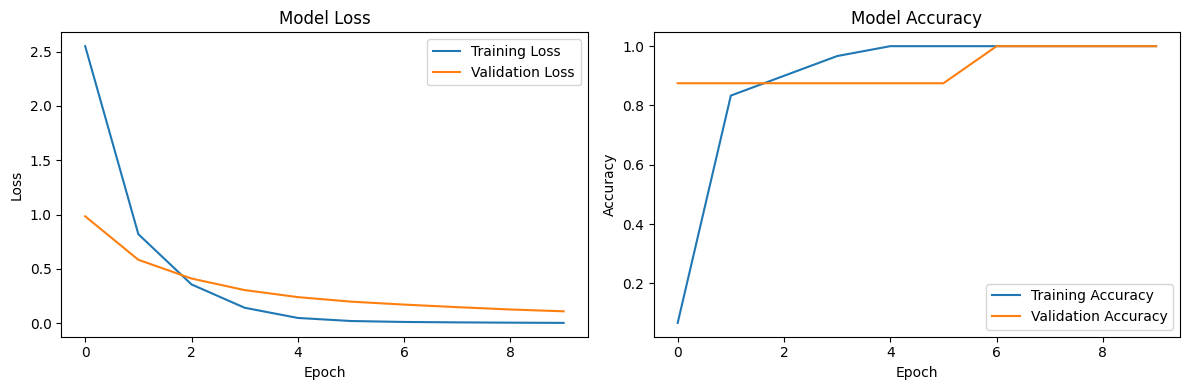


Model is ready for predictions!
You can use predict_image(image_path) to classify new images.


In [46]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Function to predict new images
def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Make prediction
    pred = model.predict(img_array)
    predicted_class = label_encoder.inverse_transform([np.argmax(pred)])[0]
    confidence = np.max(pred)
    
    return predicted_class, confidence

print("\nModel is ready for predictions!")
print("You can use predict_image(image_path) to classify new images.")

In [81]:
# Example: Predict a new image
new_image_path = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\new_images\gvb_1823_0000000210_C.png")
predicted_class, confidence = predict_image(new_image_path)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted class: Weiche
Confidence: 96.30%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Predicted class: Weiche
Confidence: 96.30%


In [ ]:
import json
from datetime import datetime

def test_all_images_in_folder(test_folder_path, output_json_name="prediction_results.json"):
    """
    Test all images in a folder and save results to a JSON file.
    
    Parameters:
    test_folder_path (str or Path): Path to the folder containing test images
    output_json_name (str): Name of the output JSON file
    
    Returns:
    dict: Dictionary containing all prediction results
    """
    test_folder = Path(test_folder_path)
    
    if not test_folder.exists():
        print(f"Error: Test folder does not exist: {test_folder}")
        return None
    
    # Find all image files in the folder
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    image_files = [f for f in test_folder.glob("*") if f.suffix.lower() in image_extensions]
    
    if not image_files:
        print(f"No image files found in {test_folder}")
        return None
    
    print(f"Found {len(image_files)} images to test in {test_folder}")
    
    # Initialize results dictionary
    results = {
        "test_folder": str(test_folder),
        "timestamp": datetime.now().isoformat(),
        "total_images": len(image_files),
        "model_categories": list(label_encoder.classes_),
        "predictions": []
    }
    
    # Test each image
    successful_predictions = 0
    failed_predictions = 0
    
    for i, image_file in enumerate(image_files, 1):
        try:
            print(f"Processing {i}/{len(image_files)}: {image_file.name}")
            
            # Make prediction
            predicted_class, confidence = predict_image(image_file)
            
            # Store result
            result = {
                "filename": image_file.name,
                "predicted_class": predicted_class,
                "confidence": float(confidence),
                "confidence_percent": f"{confidence:.2%}",
                "file_path": str(image_file)
            }
            
            results["predictions"].append(result)
            successful_predictions += 1
            
        except Exception as e:
            print(f"Error processing {image_file.name}: {e}")
            
            # Store error result
            error_result = {
                "filename": image_file.name,
                "predicted_class": "ERROR",
                "confidence": 0.0,
                "confidence_percent": "0.00%",
                "error": str(e),
                "file_path": str(image_file)
            }
            
            results["predictions"].append(error_result)
            failed_predictions += 1
    
    # Add summary statistics
    results["summary"] = {
        "successful_predictions": successful_predictions,
        "failed_predictions": failed_predictions,
        "success_rate": f"{(successful_predictions / len(image_files)) * 100:.1f}%"
    }
    
    # Add prediction distribution
    if successful_predictions > 0:
        prediction_counts = {}
        for pred in results["predictions"]:
            if pred["predicted_class"] != "ERROR":
                pred_class = pred["predicted_class"]
                prediction_counts[pred_class] = prediction_counts.get(pred_class, 0) + 1
        
        results["prediction_distribution"] = prediction_counts
    
    # Save results to JSON file
    output_path = test_folder / output_json_name
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        
        print(f"\n=== TESTING COMPLETE ===")
        print(f"Successfully tested: {successful_predictions} images")
        print(f"Failed to process: {failed_predictions} images")
        print(f"Results saved to: {output_path}")
        
        # Show prediction summary
        if "prediction_distribution" in results:
            print(f"\nPrediction Distribution:")
            for class_name, count in results["prediction_distribution"].items():
                percentage = (count / successful_predictions) * 100
                print(f"  {class_name}: {count} images ({percentage:.1f}%)")
        
        return results
        
    except Exception as e:
        print(f"Error saving results to {output_path}: {e}")
        return results

In [ ]:
# Example: Test all images in a folder
# Update this path to point to your test folder
test_folder_path = Path(r"E:\Timo Schroeder\DataScience\RAILS\LabeledData\new_images\test")

# Run batch prediction (this will save results to the same folder as prediction_results.json)
results = test_all_images_in_folder(test_folder_path)

# Optional: Display some results
if results and results["predictions"]:
    print(f"\n=== SAMPLE RESULTS ===")
    for i, pred in enumerate(results["predictions"][:5]):  # Show first 5 results
        print(f"{i+1}. {pred['filename']}: {pred['predicted_class']} ({pred['confidence_percent']})")
    
    if len(results["predictions"]) > 5:
        print(f"... and {len(results['predictions']) - 5} more results saved to JSON file")